# Acoustic Anomaly Detection based on Images with Azure AutoML for Images
## 10. Batch Audio Features Extraction using Librosa

<img src='https://github.com/retkowsky/CustomVision_Datasets/blob/master/anomaly.png?raw=true' width = 600>

Serge Retkowsky | serge.retkowsky@microsoft.com | 25-Oct-2022 | V3

<div class="alert alert-info"><b> Let's do the audio features extraction for all the files in a directory.</b></div>

In [1]:
#pip install xlwt

In [2]:
import datetime
import numpy as np
import pandas as pd
import scipy
import librosa
import librosa.display
import IPython
import xlwt
import sys

from pathlib import Path

In [3]:
sys.version

'3.8.5 (default, Sep  4 2020, 07:30:14) \n[GCC 7.3.0]'

In [4]:
now = datetime.datetime.now()
print(now)

2022-10-25 13:28:09.117711


In [5]:
def count_files(mypath):
    """
    Count files from a directory
    """
    print("Total of files in", mypath, "=",
          sum(len(files) for _, _, files in os.walk(mypath)), '\n')

    for root, _, files in os.walk(mypath):
        print(root, ":", len(files), "files")

## 1. Directory to use to generate audio features for each file

In [6]:
AUDIOFILES_DIR = "audio_samples"

In [7]:
count_files(AUDIOFILES_DIR)

Total of files in audio_samples = 122 

audio_samples : 0 files
audio_samples/KO : 61 files
audio_samples/OK : 61 files


## 2. Directory to save the results

In [8]:
FEATURES_DIR = 'audio_features'

if os.path.isdir(FEATURES_DIR) == True:
    print("Directory", FEATURES_DIR, "exists. So let's use it.")
    
if os.path.isdir(FEATURES_DIR) == False:
    print("Directory not exists. Creating directory... ", FEATURES_DIR)
    os.mkdir(FEATURES_DIR)
    print("Done.")

Directory not exists. Creating directory...  audio_features
Done.


## 3. Function to extract audio features

In [9]:
def audio_features_extraction(audio):
    """
    Audio features extraction
    """
    print(datetime.datetime.now(),
          "Generating audio features extraction from:", audio)

    # Getting some file infromations
    basename = os.path.basename(audio)
    basenamewithoutext = os.path.splitext(basename)[0]
    extension = os.path.splitext(audiofilelocation)[1][1:]
    fullfilename = audiofilelocation
    dirsname = os.path.dirname(audio)
    category = dirsname.split("/", 1)[1]

    basename_df = pd.DataFrame({'filename': [basename]})
    basenamewithoutext_df = pd.DataFrame({'basename': [basenamewithoutext]})
    ext_df = pd.DataFrame({'extension': [extension]})
    dirsname_df = pd.DataFrame({'dirsname': [dirsname]})
    fullfilename_df = pd.DataFrame({'fullfilename': [fullfilename]})
    category_df = pd.DataFrame({'category': [category]})

    # dataframe with filename and directory information
    filename_df = pd.concat([
        fullfilename_df, dirsname_df, category_df, basename_df,
        basenamewithoutext_df, ext_df
    ],
                            axis=1)

    # Loading sound file
    y, sr = librosa.load(audio)

    # Harmonic & percussive
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)

    # Chroma
    chroma = librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    chroma_std = np.std(chroma, axis=1)
    octave = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

    chroma_df = pd.DataFrame()

    for i in range(0, 12):
        chroma_df['chroma_mean_' + str(i)] = chroma_mean[i]

    for i in range(0, 12):
        chroma_df['chroma_std_' + str(i)] = chroma_mean[i]

    chroma_df.loc[0] = np.concatenate((chroma_mean, chroma_std), axis=0)

    # MFCCS
    mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfccs_std = np.std(mfccs, axis=1)
    coeffs = np.arange(0, 13)

    mfccs_df = pd.DataFrame()

    for i in range(0, 13):
        mfccs_df['mfccs_mean_' + str(i)] = mfccs_mean[i]

    for i in range(0, 13):
        mfccs_df['mfccs_std_' + str(i)] = mfccs_mean[i]

    mfccs_df.loc[0] = np.concatenate((mfccs_mean, mfccs_std), axis=0)

    # Cent
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    cent_mean = np.mean(cent)
    cent_std = np.std(cent)
    cent_skew = scipy.stats.skew(cent, axis=1)[0]

    # Contrast
    contrast = librosa.feature.spectral_contrast(y=y_harmonic, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)
    contrast_std = np.std(contrast, axis=1)
    conts = np.arange(0, 7)
    contrast_df = pd.DataFrame()

    # rolloff
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_std = np.std(rolloff)
    rolloff_skew = scipy.stats.skew(rolloff, axis=1)[0]

    spectral_df = pd.DataFrame()
    collist = ['cent_mean', 'cent_std', 'cent_skew']

    for i in range(0, 7):
        collist.append('contrast_mean_' + str(i))

    for i in range(0, 7):
        collist.append('contrast_std_' + str(i))

    collist = collist + ['rolloff_mean', 'rolloff_std', 'rolloff_skew']

    for c in collist:
        spectral_df[c] = 0

    data = np.concatenate(
        ([cent_mean, cent_std, cent_skew], contrast_mean, contrast_std,
         [rolloff_mean, rolloff_std, rolloff_std]),
        axis=0)
    spectral_df.loc[0] = data

    # zrate
    zrate = librosa.feature.zero_crossing_rate(y_harmonic)
    zrate_mean = np.mean(zrate)
    zrate_std = np.std(zrate)
    zrate_skew = scipy.stats.skew(zrate, axis=1)[0]
    zrate_df = pd.DataFrame()
    zrate_df['zrate_mean'] = 0
    zrate_df['zrate_std'] = 0
    zrate_df['zrate_skew'] = 0
    zrate_df.loc[0] = [zrate_mean, zrate_std, zrate_skew]

    # beat
    beat_df = pd.DataFrame()
    beat_df['tempo'] = tempo
    beat_df.loc[0] = tempo

    # Additional informations
    sr_df = pd.DataFrame({'sampling_rate': [sr]})
    totalsamples = np.size(y)
    duration = totalsamples / sr
    totalsamples_df = pd.DataFrame({'total_samples': [totalsamples]})
    duration_df = pd.DataFrame({'duration': [duration]})

    # Saving audiofeatures to a dataframe
    audiofeatures_df = pd.concat(
        (chroma_df, mfccs_df, spectral_df, zrate_df, beat_df), axis=1)

    # Saving all results into a single dataframe
    filesaudio_df = pd.concat(
        [filename_df, sr_df, totalsamples_df, duration_df, audiofeatures_df],
        axis=1)

    # Export to CSV for each audio file
    outputfile = FEATURES_DIR + '/' + basenamewithoutext + '_features.csv'
    filesaudio_df.to_csv(outputfile)

## 4. Let's run the function to extract audio features for each file

In [10]:
start = datetime.datetime.now()

print(start, 'Audio Features extraction...\n')

for root, dirs, files in os.walk(AUDIOFILES_DIR):
    for audiofile in files:
        audiofilelocation = root + '/' + audiofile
        audio_features_extraction(audiofilelocation)

end = datetime.datetime.now()
print('\n', end, 'End of job. Processing time:', end - start)

2022-10-25 13:29:13.723171 Audio Features extraction...

2022-10-25 13:29:13.793069 Generating audio features extraction from: audio_samples/KO/machine_KO_1.wav
2022-10-25 13:29:16.124523 Generating audio features extraction from: audio_samples/KO/machine_KO_10.wav
2022-10-25 13:29:17.594290 Generating audio features extraction from: audio_samples/KO/machine_KO_11.wav
2022-10-25 13:29:19.036441 Generating audio features extraction from: audio_samples/KO/machine_KO_12.wav
2022-10-25 13:29:20.476144 Generating audio features extraction from: audio_samples/KO/machine_KO_13.wav
2022-10-25 13:29:21.932754 Generating audio features extraction from: audio_samples/KO/machine_KO_14.wav
2022-10-25 13:29:23.553014 Generating audio features extraction from: audio_samples/KO/machine_KO_15.wav
2022-10-25 13:29:25.005511 Generating audio features extraction from: audio_samples/KO/machine_KO_16.wav
2022-10-25 13:29:26.473732 Generating audio features extraction from: audio_samples/KO/machine_KO_17.wav

2022-10-25 13:31:04.453705 Generating audio features extraction from: audio_samples/OK/machine_OK_25.wav
2022-10-25 13:31:05.943796 Generating audio features extraction from: audio_samples/OK/machine_OK_26.wav
2022-10-25 13:31:07.342643 Generating audio features extraction from: audio_samples/OK/machine_OK_27.wav
2022-10-25 13:31:08.763243 Generating audio features extraction from: audio_samples/OK/machine_OK_28.wav
2022-10-25 13:31:10.128919 Generating audio features extraction from: audio_samples/OK/machine_OK_29.wav
2022-10-25 13:31:11.460132 Generating audio features extraction from: audio_samples/OK/machine_OK_3.wav
2022-10-25 13:31:12.812715 Generating audio features extraction from: audio_samples/OK/machine_OK_30.wav
2022-10-25 13:31:14.280133 Generating audio features extraction from: audio_samples/OK/machine_OK_31.wav
2022-10-25 13:31:15.617847 Generating audio features extraction from: audio_samples/OK/machine_OK_32.wav
2022-10-25 13:31:17.020286 Generating audio features ext

## 5. Results

In [11]:
count_files(FEATURES_DIR)

Total of files in audio_features = 122 

audio_features : 122 files


In [12]:
os.chdir(FEATURES_DIR)

filepaths = [f for f in os.listdir() if f.endswith('.csv')] 

# Taking all the CSV files into a single dataframe
audiofeaturesdf = pd.concat(map(pd.read_csv, filepaths))
del audiofeaturesdf['Unnamed: 0']  # Cleaning the df
audiofeaturesdf = audiofeaturesdf.reset_index(drop=True)  # Clean index

os.chdir('..')

In [13]:
audiofeaturesdf.head(10)

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
0,audio_samples/KO/machine_KO_10.wav,audio_samples/KO,KO,machine_KO_10.wav,machine_KO_10,wav,22050,154350,7.0,0.207503,...,1.687127,1.348918,4.272936,4407.604253,414.652790,414.652790,0.041735,0.007198,0.174384,89.102909
1,audio_samples/KO/machine_KO_11.wav,audio_samples/KO,KO,machine_KO_11.wav,machine_KO_11,wav,22050,154350,7.0,0.254620,...,1.659826,1.223536,4.400989,4501.437681,387.931940,387.931940,0.043779,0.006834,-0.067536,89.102909
2,audio_samples/KO/machine_KO_12.wav,audio_samples/KO,KO,machine_KO_12.wav,machine_KO_12,wav,22050,154350,7.0,0.209314,...,1.754141,1.625297,3.865849,4504.147157,507.148701,507.148701,0.044434,0.008300,0.590730,89.102909
3,audio_samples/KO/machine_KO_13.wav,audio_samples/KO,KO,machine_KO_13.wav,machine_KO_13,wav,22050,154350,7.0,0.256801,...,1.821594,1.314911,4.268477,4438.014555,488.818772,488.818772,0.044020,0.007560,0.081320,129.199219
4,audio_samples/KO/machine_KO_14.wav,audio_samples/KO,KO,machine_KO_14.wav,machine_KO_14,wav,22050,154350,7.0,0.260920,...,1.809934,1.436137,4.342983,4489.744154,418.799064,418.799064,0.044665,0.007445,0.094036,89.102909
5,audio_samples/KO/machine_KO_15.wav,audio_samples/KO,KO,machine_KO_15.wav,machine_KO_15,wav,22050,154350,7.0,0.250668,...,1.590028,1.412233,4.306663,4621.260687,411.167343,411.167343,0.046744,0.007470,0.163075,172.265625
6,audio_samples/KO/machine_KO_16.wav,audio_samples/KO,KO,machine_KO_16.wav,machine_KO_16,wav,22050,154350,7.0,0.212568,...,1.730367,1.322294,4.497835,4554.664622,477.516466,477.516466,0.044503,0.008391,-0.116057,89.102909
7,audio_samples/KO/machine_KO_17.wav,audio_samples/KO,KO,machine_KO_17.wav,machine_KO_17,wav,22050,154350,7.0,0.254056,...,1.723347,1.283012,4.359413,4501.116822,447.835210,447.835210,0.040455,0.007335,0.323728,89.102909
8,audio_samples/KO/machine_KO_18.wav,audio_samples/KO,KO,machine_KO_18.wav,machine_KO_18,wav,22050,154350,7.0,0.295805,...,1.734805,1.301398,4.176879,4621.367640,466.367128,466.367128,0.045609,0.008622,-0.160810,89.102909
9,audio_samples/KO/machine_KO_19.wav,audio_samples/KO,KO,machine_KO_19.wav,machine_KO_19,wav,22050,154350,7.0,0.204857,...,1.736602,1.416512,4.189162,4753.205033,359.446599,359.446599,0.046316,0.008715,0.307786,89.102909


In [14]:
audiofeaturesdf.shape

(122, 83)

In [15]:
audiofeaturesdf.columns

Index(['fullfilename', 'dirsname', 'category', 'filename', 'basename',
       'extension', 'sampling_rate', 'total_samples', 'duration',
       'chroma_mean_0', 'chroma_mean_1', 'chroma_mean_2', 'chroma_mean_3',
       'chroma_mean_4', 'chroma_mean_5', 'chroma_mean_6', 'chroma_mean_7',
       'chroma_mean_8', 'chroma_mean_9', 'chroma_mean_10', 'chroma_mean_11',
       'chroma_std_0', 'chroma_std_1', 'chroma_std_2', 'chroma_std_3',
       'chroma_std_4', 'chroma_std_5', 'chroma_std_6', 'chroma_std_7',
       'chroma_std_8', 'chroma_std_9', 'chroma_std_10', 'chroma_std_11',
       'mfccs_mean_0', 'mfccs_mean_1', 'mfccs_mean_2', 'mfccs_mean_3',
       'mfccs_mean_4', 'mfccs_mean_5', 'mfccs_mean_6', 'mfccs_mean_7',
       'mfccs_mean_8', 'mfccs_mean_9', 'mfccs_mean_10', 'mfccs_mean_11',
       'mfccs_mean_12', 'mfccs_std_0', 'mfccs_std_1', 'mfccs_std_2',
       'mfccs_std_3', 'mfccs_std_4', 'mfccs_std_5', 'mfccs_std_6',
       'mfccs_std_7', 'mfccs_std_8', 'mfccs_std_9', 'mfccs_std_10',
  

In [16]:
audiofeaturesdf.describe()

,sampling_rate,total_samples,duration,chroma_mean_0,chroma_mean_1,chroma_mean_2,chroma_mean_3,chroma_mean_4,chroma_mean_5,chroma_mean_6,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
count,122.0,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,...,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000,122.000000
mean,22050.0,153183.885246,6.947115,0.256014,0.096849,0.018883,0.005733,0.035318,0.214208,0.240684,...,1.707834,1.302730,4.088079,4664.787692,420.106882,420.106882,0.048327,0.008571,0.076895,108.375900
std,0.0,9069.934393,0.411335,0.031143,0.038376,0.012205,0.005535,0.029643,0.031075,0.047745,...,0.088822,0.075221,0.247915,129.391998,68.570409,68.570409,0.003986,0.001031,0.216112,33.200135
min,22050.0,83217.000000,3.774014,0.188875,0.004705,0.003091,0.000000,0.000000,0.134658,0.130089,...,1.508113,1.155480,3.485877,4346.819300,269.640466,269.640466,0.039852,0.006078,-0.363726,89.102909
25%,22050.0,154350.000000,7.000000,0.225710,0.067572,0.009924,0.001502,0.013512,0.193511,0.212933,...,1.656098,1.249198,3.939090,4568.060485,378.114109,378.114109,0.045546,0.007744,-0.084345,89.102909
50%,22050.0,154350.000000,7.000000,0.257555,0.102908,0.014943,0.003994,0.028536,0.210491,0.241342,...,1.705757,1.300551,4.137765,4659.638987,414.565745,414.565745,0.048476,0.008630,0.065217,89.102909
75%,22050.0,154350.000000,7.000000,0.283674,0.120758,0.023548,0.008489,0.048341,0.233583,0.259929,...,1.769236,1.344990,4.264405,4774.292598,465.569150,465.569150,0.050921,0.009270,0.223775,123.815918
max,22050.0,154350.000000,7.000000,0.307707,0.194028,0.068849,0.025453,0.124541,0.349846,0.359114,...,1.923476,1.625297,4.606771,4946.183888,593.337336,593.337336,0.059869,0.011887,0.909389,184.570312


In [17]:
audiofeaturesdf['category'].value_counts()

OK    61
KO    61
Name: category, dtype: int64

Text(0, 0.5, 'Number of files')

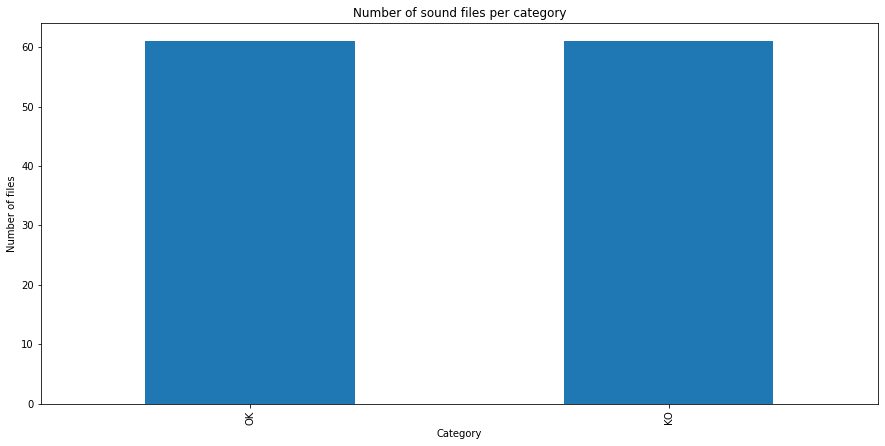

In [18]:
%matplotlib inline

ax = audiofeaturesdf['category'].value_counts().plot(
    kind='bar', figsize=(15, 7), title="Number of sound files per category")
ax.set_xlabel("Category")
ax.set_ylabel("Number of files")

## 6. EDA

In [19]:
# Let's create a sample for the EDA

pctsample = 0.1
dfsample = audiofeaturesdf.sample(frac=pctsample)

In [20]:
dfsample.head()

,fullfilename,dirsname,category,filename,basename,extension,sampling_rate,total_samples,duration,chroma_mean_0,...,contrast_std_4,contrast_std_5,contrast_std_6,rolloff_mean,rolloff_std,rolloff_skew,zrate_mean,zrate_std,zrate_skew,tempo
34,audio_samples/KO/machine_KO_41.wav,audio_samples/KO,KO,machine_KO_41.wav,machine_KO_41,wav,22050,154350,7.000000,0.260584,...,1.705195,1.341721,4.180576,4685.075975,426.956574,426.956574,0.052613,0.009588,0.212459,89.102909
31,audio_samples/KO/machine_KO_39.wav,audio_samples/KO,KO,machine_KO_39.wav,machine_KO_39,wav,22050,154350,7.000000,0.301744,...,1.678651,1.323780,4.160196,4666.430502,522.786233,522.786233,0.047315,0.009270,-0.002360,135.999178
117,audio_samples/OK/machine_OK_61.wav,audio_samples/OK,OK,machine_OK_61.wav,machine_OK_61,wav,22050,83217,3.774014,0.225548,...,1.577671,1.219854,4.602928,4814.388270,445.426375,445.426375,0.055718,0.010076,-0.126979,89.102909
73,audio_samples/OK/machine_OK_21.wav,audio_samples/OK,OK,machine_OK_21.wav,machine_OK_21,wav,22050,154350,7.000000,0.304858,...,1.743531,1.315048,4.147122,4563.434768,314.329218,314.329218,0.044230,0.007649,0.142765,89.102909
20,audio_samples/KO/machine_KO_29.wav,audio_samples/KO,KO,machine_KO_29.wav,machine_KO_29,wav,22050,154350,7.000000,0.206262,...,1.780518,1.328199,3.919138,4596.768451,525.890010,525.890010,0.049190,0.008671,-0.104756,172.265625


## 7. Export features to CSV and Excel files

In [21]:
csv_output = FEATURES_DIR + '/features.csv'
audiofeaturesdf.to_csv(csv_output)

In [22]:
excel_output = FEATURES_DIR + '/features.xls'
audiofeaturesdf.to_excel(excel_output)

In [23]:
os.listdir(FEATURES_DIR)

['features.csv',
 'features.xls',
 'machine_KO_10_features.csv',
 'machine_KO_11_features.csv',
 'machine_KO_12_features.csv',
 'machine_KO_13_features.csv',
 'machine_KO_14_features.csv',
 'machine_KO_15_features.csv',
 'machine_KO_16_features.csv',
 'machine_KO_17_features.csv',
 'machine_KO_18_features.csv',
 'machine_KO_19_features.csv',
 'machine_KO_1_features.csv',
 'machine_KO_20_features.csv',
 'machine_KO_21_features.csv',
 'machine_KO_22_features.csv',
 'machine_KO_23_features.csv',
 'machine_KO_24_features.csv',
 'machine_KO_25_features.csv',
 'machine_KO_26_features.csv',
 'machine_KO_27_features.csv',
 'machine_KO_28_features.csv',
 'machine_KO_29_features.csv',
 'machine_KO_2_features.csv',
 'machine_KO_30_features.csv',
 'machine_KO_31_features.csv',
 'machine_KO_32_features.csv',
 'machine_KO_33_features.csv',
 'machine_KO_34_features.csv',
 'machine_KO_35_features.csv',
 'machine_KO_36_features.csv',
 'machine_KO_37_features.csv',
 'machine_KO_38_features.csv',
 'machi

In [24]:
from IPython.display import FileLink

CSVLINK = FileLink(path=csv_output)
print("Click to download the file:")
CSVLINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd13v2/code/Users/seretkow/Sound/MachineSoundAnomaly/audio_features/features.csv

In [25]:
XLSLINK = FileLink(path=excel_output)
print("Click to download the file:")
XLSLINK

Click to download the file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/standardd13v2/code/Users/seretkow/Sound/MachineSoundAnomaly/audio_features/features.xls

> We will use AutoML for Classification in order to predict the music genre with the extracted features

Note: All these Python notebooks were made for demo purposes. They were not designed for production usage. Some feature can be currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see Supplemental Terms of Use for Microsoft Azure Previews. https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/